# Disaster Analysis and Prediction

This notebook performs an exploratory data analysis (EDA) on a disaster dataset, preprocesses the data, and builds machine learning models to analyze and potentially predict disaster impacts. The goal is to provide insights into disaster patterns and build predictive capabilities for better disaster response and mitigation.

## 1. Setup and Data Loading

This section handles the necessary library imports and loads the dataset into a pandas DataFrame.

### 1.1. Import Libraries

This cell imports all the required Python libraries for data manipulation, visualization, machine learning, and utility functions.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer # Added for imputation

import re
import string


### 1.2. Load Dataset

This cell loads the `disaster_data_set.csv` file into a pandas DataFrame. The `encoding='latin1'` is used to handle potential character encoding issues in the CSV file.

In [ ]:
try:
    df = pd.read_csv("/content/disaster_data_set.csv", encoding='latin1')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'disaster_data_set.csv' not found. Please ensure the file is in the correct path.")
    df = pd.DataFrame() # Create an empty DataFrame to avoid errors in subsequent cells
except Exception as e:
    print(f"An error occurred during data loading: {e}")
    df = pd.DataFrame() # Create an empty DataFrame

Dataset loaded successfully.


### 1.3. Initial Data Inspection

This cell displays the shape of the DataFrame (number of rows and columns), lists all column names, and shows the first few rows of the dataset to provide a quick overview of its structure and content.

In [ ]:
if not df.empty:
    print("Dataset shape:", df.shape)
    print("\nColumns:", df.columns.tolist()) # Using tolist() for cleaner output
    print("\nSample Data:")
    print(df.head())
else:
    print("DataFrame is empty. Cannot perform initial inspection.")

Dataset shape: (15784, 46)

Columns: ['DisNo.', 'Historic', 'Classification Key', 'Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 'External IDs', 'Event Name', 'ISO', 'Country', 'Subregion', 'Region', 'Location', 'Origin', 'Associated Types', 'OFDA/BHA Response', 'Appeal', 'Declaration', "AID Contribution ('000 US$)", 'Magnitude', 'Magnitude Scale', 'Latitude', 'Longitude', 'River Basin', 'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day', 'Total Deaths', 'No. Injured', 'No. Affected', 'No. Homeless', 'Total Affected', "Reconstruction Costs ('000 US$)", "Reconstruction Costs, Adjusted ('000 US$)", "Insured Damage ('000 US$)", "Insured Damage, Adjusted ('000 US$)", "Total Damage ('000 US$)", "Total Damage, Adjusted ('000 US$)", 'CPI', 'Admin Units', 'Entry Date', 'Last Update']

Sample Data:
          DisNo. Historic Classification Key Disaster Group Disaster Subgroup  \
0  1999-9388-DJI       No    nat-cli-dro-dro        Natural    

## 2. Data Cleaning and Preprocessing

This section focuses on cleaning the data, handling missing values, and preparing features for machine learning models.

### 2.1. Text Cleaning Function

This utility function (`clean_text`) preprocesses text data by converting it to lowercase, removing URLs, punctuation, numbers, and extra spaces. This is useful for cleaning textual features before applying techniques like TF-IDF.

In [ ]:
def clean_text(text):
    if pd.isna(text) or text is None: # Handle NaN values
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation and numbers
    return re.sub(r'\s+', ' ', text).strip()

### 2.2. Numeric Column Conversion and Correlation Analysis

This cell identifies numeric columns, converts them to a proper numeric type (handling commas and non-numeric entries), and then generates a correlation heatmap to visualize relationships between these disaster impact features.

Available columns for numeric conversion: ['DisNo.', 'Historic', 'Classification Key', 'Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 'External IDs', 'Event Name', 'ISO', 'Country', 'Subregion', 'Region', 'Location', 'Origin', 'Associated Types', 'OFDA/BHA Response', 'Appeal', 'Declaration', "AID Contribution ('000 US$)", 'Magnitude', 'Magnitude Scale', 'Latitude', 'Longitude', 'River Basin', 'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day', 'Total Deaths', 'No. Injured', 'No. Affected', 'No. Homeless', 'Total Affected', "Reconstruction Costs ('000 US$)", "Reconstruction Costs, Adjusted ('000 US$)", "Insured Damage ('000 US$)", "Insured Damage, Adjusted ('000 US$)", "Total Damage ('000 US$)", "Total Damage, Adjusted ('000 US$)", 'CPI', 'Admin Units', 'Entry Date', 'Last Update']


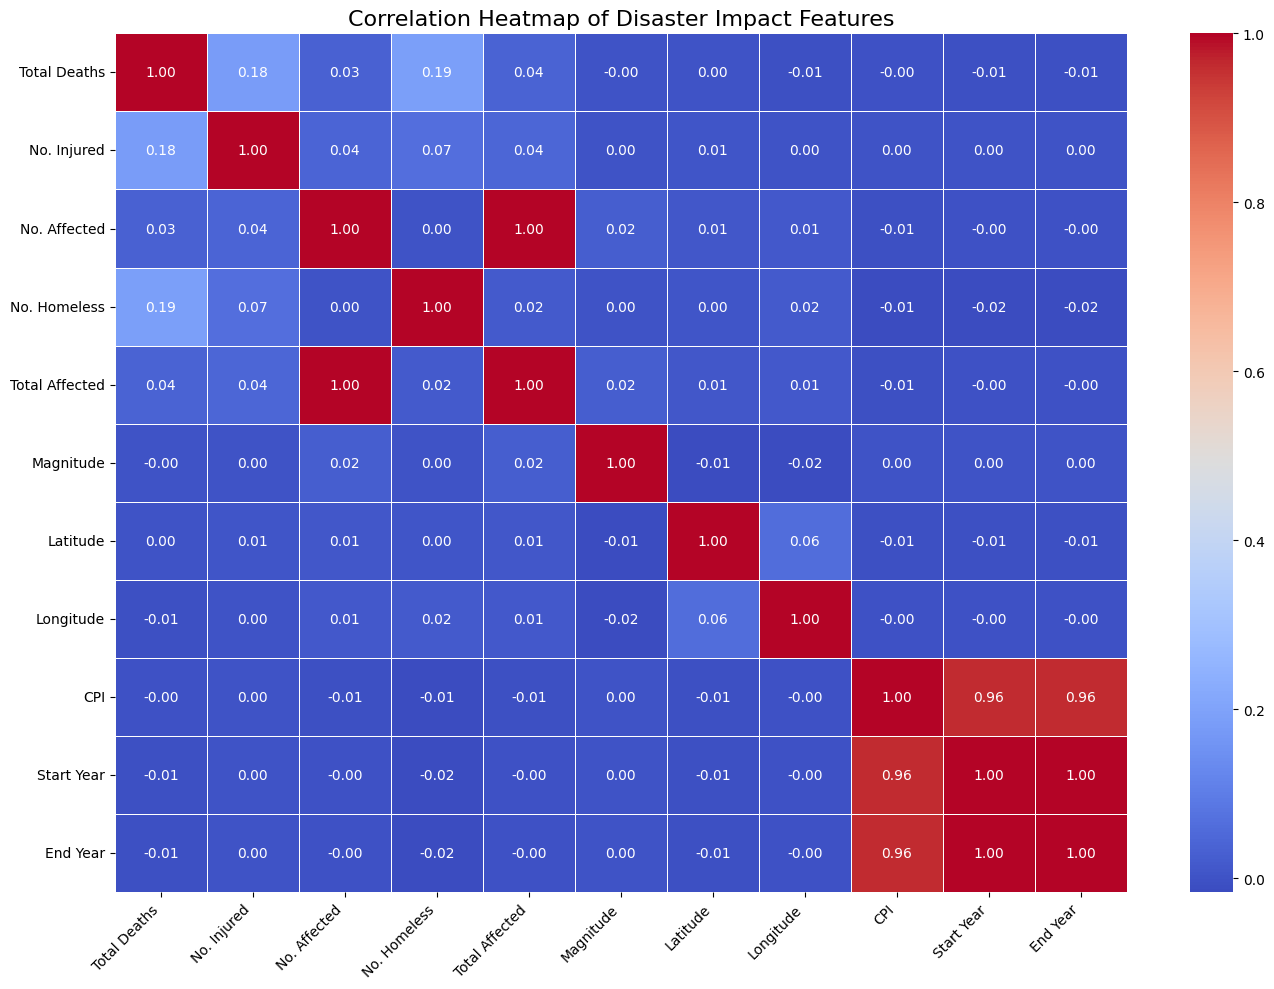

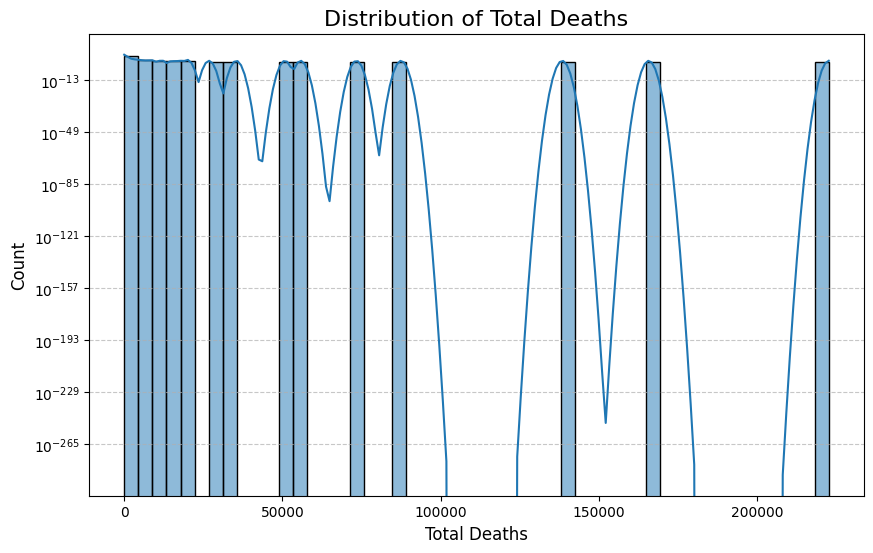


Summary statistics for 'Total Deaths':
count     15784.000000
mean        112.192790
std        2765.720335
min           0.000000
25%          11.000000
50%          16.000000
75%          26.000000
max      222570.000000
Name: Total Deaths, dtype: float64


In [ ]:
if not df.empty:
    # Print available columns to debug (already done in initial inspection, but good for context)
    print("Available columns for numeric conversion:", df.columns.tolist())

    # Define potential numeric columns based on common disaster datasets
    numeric_columns = [
        'Total Deaths', 'No. Injured', 'No. Affected', 'No. Homeless',
        'Total Affected', "Reconstruction Costs ('000 US$')",
        "Reconstruction Costs, Adjusted ('000 US$')",
        "Insured Damage ('000 US$')", "Insured Damage, Adjusted ('000 US$')",
        "AID Contribution ('000 US$')", 'Magnitude', 'Latitude', 'Longitude',
        'CPI', 'Start Year', 'End Year' # Added CPI, Start/End Year as they can be numeric
    ]

    # Filter numeric_columns to only include columns that exist in df
    existing_numeric_columns = [col for col in numeric_columns if col in df.columns]

    # Convert existing columns to numeric, handling common parsing issues (commas, spaces)
    for col in existing_numeric_columns:
        df[col] = pd.to_numeric(
            df[col].astype(str).str.replace(',', '', regex=False).str.strip(), # Use regex=False for literal string replacement
            errors='coerce' # Convert invalid parsing into NaN
        )

    # Impute missing numeric values (e.g., with median or mean)
    # Using median as it's less sensitive to outliers than mean
    imputer_numeric = SimpleImputer(strategy='median')
    df[existing_numeric_columns] = imputer_numeric.fit_transform(df[existing_numeric_columns])

    # Correlation heatmap (only for existing and now numeric columns)
    if existing_numeric_columns:
        plt.figure(figsize=(14, 10)) # Increased figure size for better readability
        corr = df[existing_numeric_columns].corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
        plt.title('Correlation Heatmap of Disaster Impact Features', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout() # Adjust layout to prevent labels from overlapping
        plt.show()
    else:
        print("No numeric columns found for correlation heatmap after filtering.")

    # Distribution plot for a key impact metric (e.g., Total Deaths)
    column_to_plot = 'Total Deaths'

    if column_to_plot in df.columns:
        data = df[column_to_plot].dropna() # Drop NaN values for plotting

        if len(data) > 0:
            plt.figure(figsize=(10, 6))
            sns.histplot(x=data, kde=True, bins=50) # Increased bins for more detail
            plt.title(f'Distribution of {column_to_plot}', fontsize=16)
            plt.xlabel(column_to_plot, fontsize=12)
            plt.ylabel('Count', fontsize=12)
            plt.yscale('log') # Use log scale for y-axis to better visualize skewed data
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.show()
        else:
            print(f"No valid data found in '{column_to_plot}' for histogram after dropping NaNs.")
    else:
        print(f"Column '{column_to_plot}' not found in DataFrame. Available columns: {df.columns.tolist()}")

    print(f"\nSummary statistics for '{column_to_plot}':")
    print(df[column_to_plot].describe())
else:
    print("DataFrame is empty. Skipping numeric conversion and correlation analysis.")

### 2.3. Feature Engineering: Target Variable Creation

This section defines a target variable for machine learning. Here, `Is_Severe_Disaster` is created as a binary classification target based on `Total Deaths` exceeding a certain threshold. This transforms the problem into a classification task (predicting severe vs. non-severe disasters).

Severe disaster death threshold (top 10%): 62 deaths

Distribution of 'Is_Severe_Disaster' (0: Not Severe, 1: Severe):
Is_Severe_Disaster
0    14201
1     1583
Name: count, dtype: int64


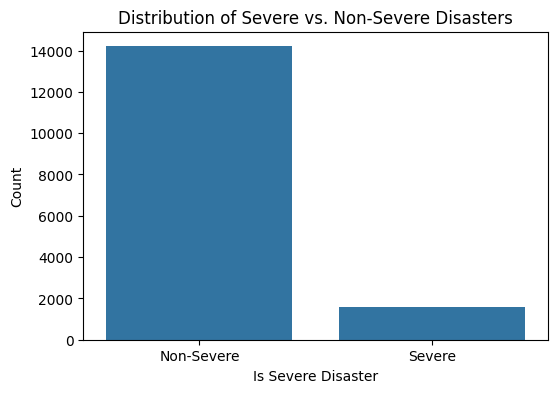

In [ ]:
if not df.empty:
    # Define a threshold for 'severe' disaster based on 'Total Deaths'
    # This threshold can be adjusted based on domain knowledge or data distribution
    death_threshold = df['Total Deaths'].quantile(0.90) # Top 10% deadliest events
    print(f"Severe disaster death threshold (top 10%): {death_threshold:.0f} deaths")

    df['Is_Severe_Disaster'] = (df['Total Deaths'] >= death_threshold).astype(int)
    print("\nDistribution of 'Is_Severe_Disaster' (0: Not Severe, 1: Severe):")
    print(df['Is_Severe_Disaster'].value_counts())

    # Visualize the distribution of the new target variable
    plt.figure(figsize=(6, 4))
    sns.countplot(x='Is_Severe_Disaster', data=df)
    plt.title('Distribution of Severe vs. Non-Severe Disasters')
    plt.xlabel('Is Severe Disaster')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Non-Severe', 'Severe'])
    plt.show()
else:
    print("DataFrame is empty. Skipping target variable creation.")

### 2.4. Handling Categorical Features

This cell identifies categorical columns and applies one-hot encoding to convert them into a numerical format suitable for machine learning models. This is crucial as most ML algorithms cannot directly process string categories.

In [ ]:
if not df.empty:
    # Identify categorical columns that are relevant and not too high cardinality
    # Exclude 'Admin Units' and 'Location' due to very high cardinality/complex structure
    categorical_cols = [
        'Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype',
        'Country', 'Region', 'Subregion', 'OFDA/BHA Response', 'Appeal', 'Declaration'
    ]

    # Filter to only include columns that exist in df and are of object/category dtype
    existing_categorical_cols = [col for col in categorical_cols if col in df.columns and df[col].dtype == 'object']

    print("Categorical columns to encode:", existing_categorical_cols)

    # Apply one-hot encoding
    if existing_categorical_cols:
        df_encoded = pd.get_dummies(df, columns=existing_categorical_cols, dummy_na=False, drop_first=True) # drop_first to avoid multicollinearity
        print("\nShape after one-hot encoding:", df_encoded.shape)
        print("New columns created by encoding:", [col for col in df_encoded.columns if any(cat_col in col for cat_col in existing_categorical_cols)])
    else:
        df_encoded = df.copy()
        print("No relevant categorical columns found or encoded.")
else:
    print("DataFrame is empty. Skipping categorical feature handling.")
    df_encoded = pd.DataFrame()

Categorical columns to encode: ['Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 'Country', 'Region', 'Subregion', 'OFDA/BHA Response', 'Appeal', 'Declaration']

Shape after one-hot encoding: (15784, 381)
New columns created by encoding: ['Disaster Group_Technological', 'Disaster Subgroup_Climatological', 'Disaster Subgroup_Extra-terrestrial', 'Disaster Subgroup_Geophysical', 'Disaster Subgroup_Hydrological', 'Disaster Subgroup_Industrial accident', 'Disaster Subgroup_Meteorological', 'Disaster Subgroup_Miscellaneous accident', 'Disaster Subgroup_Transport', 'Disaster Type_Animal incident', 'Disaster Type_Chemical spill', 'Disaster Type_Collapse (Industrial)', 'Disaster Type_Collapse (Miscellaneous)', 'Disaster Type_Drought', 'Disaster Type_Earthquake', 'Disaster Type_Epidemic', 'Disaster Type_Explosion (Industrial)', 'Disaster Type_Explosion (Miscellaneous)', 'Disaster Type_Extreme temperature', 'Disaster Type_Fire (Industrial)', 'Disaster Type_Fire (Miscell

## 3. Machine Learning Modeling

This section prepares the data for machine learning, trains various models, and evaluates their performance.

### 3.1. Data Splitting

This cell splits the processed dataset (`df_encoded`) into training and testing sets. The `X` contains features (independent variables), and `y` is the target variable (`Is_Severe_Disaster`). This split is essential for evaluating model performance on unseen data.

In [ ]:
if not df_encoded.empty and 'Is_Severe_Disaster' in df_encoded.columns:
    # Define features (X) and target (y)
    # Exclude columns that are directly related to the target or not suitable as features
    exclude_cols = [
        'Is_Severe_Disaster', 'Total Deaths', 'No. Injured', 'No. Affected', 'No. Homeless', 'Total Affected',
        'DisNo.', 'Historic', 'Classification Key', 'External IDs', 'Event Name', 'Location', 'Admin Units',
        'Entry Date', 'Last Update', 'Origin', 'Associated Types', 'ISO' # Explicitly exclude 'ISO' here
    ]

    # Filter exclude_cols to only include columns that exist in df_encoded
    existing_exclude_cols = [col for col in exclude_cols if col in df_encoded.columns]

    features = [col for col in df_encoded.columns if col not in existing_exclude_cols]

    X = df_encoded[features]
    y = df_encoded['Is_Severe_Disaster']

    # Drop columns from X that became all NaN during numeric conversion/imputation
    # This can happen if a column was entirely non-numeric
    X = X.dropna(axis=1, how='all')

    # Align columns after one-hot encoding if needed (for consistency)
    # This is typically handled by Pipeline, but good to be aware.

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")

    print("\nDistribution of target in training set:")
    print(y_train.value_counts(normalize=True))
    print("\nDistribution of target in test set:")
    print(y_test.value_counts(normalize=True))

else:
    print("DataFrame is empty or 'Is_Severe_Disaster' column is missing. Skipping data splitting.")
    X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(), pd.Series()

X_train shape: (11048, 363)
X_test shape: (4736, 363)
y_train shape: (11048,)
y_test shape: (4736,)

Distribution of target in training set:
Is_Severe_Disaster
0    0.89971
1    0.10029
Name: proportion, dtype: float64

Distribution of target in test set:
Is_Severe_Disaster
0    0.899704
1    0.100296
Name: proportion, dtype: float64


### 3.2. Model Training and Evaluation (Logistic Regression)

This section trains a Logistic Regression model, a common choice for binary classification. It also includes `StandardScaler` in a `Pipeline` to normalize numerical features, which is crucial for many models, including Logistic Regression. The model's performance is then evaluated using a classification report, confusion matrix, and accuracy score.

In [ ]:
if not X_train.empty and not y_train.empty:
    # Ensure X_train and X_test have consistent columns before scaling
    common_cols = list(set(X_train.columns) & set(X_test.columns))
    X_train_aligned = X_train[common_cols]
    X_test_aligned = X_test[common_cols]

    # Explicitly remove 'Magnitude Scale' column if it exists
    if 'Magnitude Scale' in X_train_aligned.columns:
        X_train_aligned = X_train_aligned.drop('Magnitude Scale', axis=1)
    if 'Magnitude Scale' in X_test_aligned.columns:
        X_test_aligned = X_test_aligned.drop('Magnitude Scale', axis=1)

    # Explicitly convert all columns to numeric, coercing errors
    for col in X_train_aligned.columns:
        X_train_aligned[col] = pd.to_numeric(X_train_aligned[col], errors='coerce')
    for col in X_test_aligned.columns:
        X_test_aligned[col] = pd.to_numeric(X_test_aligned[col], errors='coerce')

    # Impute any remaining NaN values after coercion (using the median strategy)
    imputer_final = SimpleImputer(strategy='median')
    X_train_aligned = imputer_final.fit_transform(X_train_aligned)
    X_test_aligned = imputer_final.transform(X_test_aligned)


    # Define the Logistic Regression pipeline
    pipeline_lr = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(random_state=42, solver='liblinear')) # 'liblinear' is good for small datasets and L1/L2 regularization
    ])

    # Train the model
    print("Training Logistic Regression model...")
    start_time_lr = time.time()
    pipeline_lr.fit(X_train_aligned, y_train)
    end_time_lr = time.time()
    print(f"Logistic Regression training time: {end_time_lr - start_time_lr:.2f} seconds")

    # Make predictions
    y_pred_lr = pipeline_lr.predict(X_test_aligned)

    # Evaluate the model
    print("\n--- Logistic Regression Evaluation ---")
    print("Accuracy:", accuracy_score(y_test, y_pred_lr))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
    print("\nClassification Report:\n", classification_report(y_test, y_pred_lr, zero_division=0)) # zero_division handles cases where a class has no predicted samples
else:
    print("Training data not available for Logistic Regression. Skipping model training.")

Training Logistic Regression model...
Logistic Regression training time: 5.99 seconds

--- Logistic Regression Evaluation ---
Accuracy: 0.9045608108108109

Confusion Matrix:
 [[4220   41]
 [ 411   64]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      4261
           1       0.61      0.13      0.22       475

    accuracy                           0.90      4736
   macro avg       0.76      0.56      0.58      4736
weighted avg       0.88      0.90      0.88      4736



### 3.3. Model Training and Evaluation (Random Forest Classifier)

This section trains a Random Forest Classifier, an ensemble learning method known for its robustness and good performance on various datasets. It also includes `StandardScaler` in a `Pipeline`. The model's performance is then evaluated using a classification report, confusion matrix, and accuracy score.


Training Random Forest Classifier model...
Random Forest training time: 3.86 seconds

--- Random Forest Evaluation ---
Accuracy: 0.9096283783783784

Confusion Matrix:
 [[4224   37]
 [ 391   84]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95      4261
           1       0.69      0.18      0.28       475

    accuracy                           0.91      4736
   macro avg       0.80      0.58      0.62      4736
weighted avg       0.89      0.91      0.88      4736



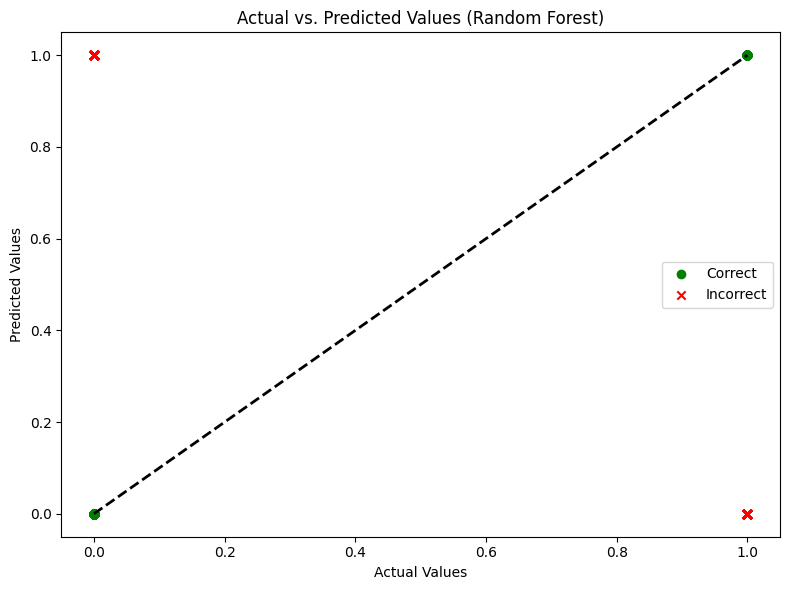

In [25]:
if not X_train.empty and not y_train.empty:
    # Define the Random Forest pipeline
    pipeline_rf = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'))
    ])

    # Train the model
    print("\nTraining Random Forest Classifier model...")
    start_time_rf = time.time()
    pipeline_rf.fit(X_train_aligned, y_train)
    end_time_rf = time.time()
    print(f"Random Forest training time: {end_time_rf - start_time_rf:.2f} seconds")

    # Make predictions
    y_pred_rf = pipeline_rf.predict(X_test_aligned)

    # Evaluate the model
    print("\n--- Random Forest Evaluation ---")
    print("Accuracy:", accuracy_score(y_test, y_pred_rf))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
    print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))

    # Create actual vs. predicted scatter plot
    plt.figure(figsize=(8, 6))
    # Use different markers/colors for correct vs. incorrect predictions
    correct = (y_test == y_pred_rf)
    plt.scatter(y_test[correct], y_pred_rf[correct], c='green', marker='o', label='Correct')
    plt.scatter(y_test[~correct], y_pred_rf[~correct], c='red', marker='x', label='Incorrect')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for perfect predictions
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted Values (Random Forest)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Training data not available for Random Forest. Skipping model training.")

### 3.4. (Optional) Regression Model (Linear Regression) - for comparison/alternative task

This cell demonstrates training a Linear Regression model. While the primary target (`Is_Severe_Disaster`) is for classification, Linear Regression could be used to predict continuous impact metrics like `Total Deaths` directly. The example here, however, seems to apply it to a classification context by rounding. It's important to note that Linear Regression is generally not suitable for classification tasks; a dedicated classification model like Logistic Regression or Random Forest is preferred.


Training Linear Regression model...
Linear Regression training time: 0.41 seconds

--- Linear Regression (as classifier) Evaluation ---
Accuracy (after rounding): 0.903293918918919

Confusion Matrix:
 [[4253    8    0    0    0]
 [ 447   25    1    1    1]
 [   0    0    0    0    0]
 [   0    0    0    0    0]
 [   0    0    0    0    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      4261
           1       0.76      0.05      0.10       475
           2       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.90      4736
   macro avg       0.33      0.21      0.21      4736
weighted avg       0.89      0.90      0.86      4736



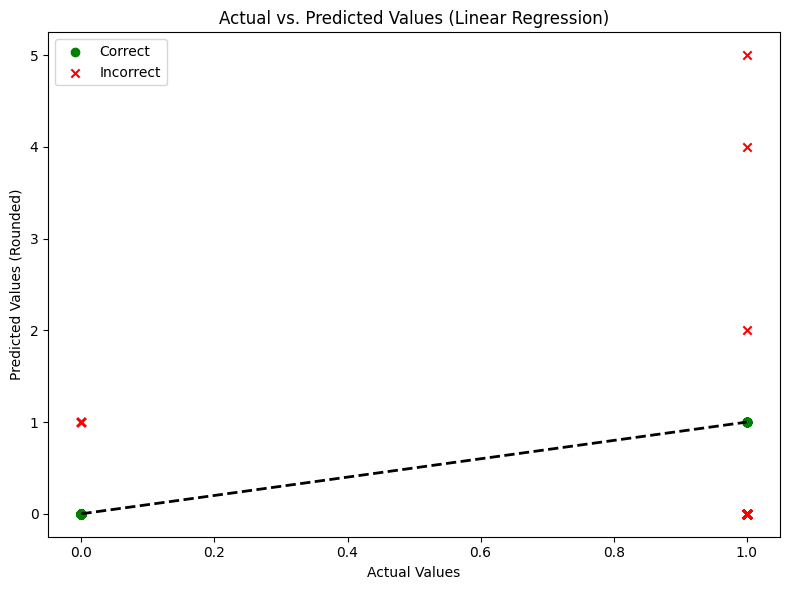

In [23]:
if not X_train.empty and not y_train.empty:
    # Define the Linear Regression pipeline
    pipeline_lr_reg = Pipeline([
        ('scaler', StandardScaler()),
        ('linreg', LinearRegression())
    ])

    # Train the model
    print("\nTraining Linear Regression model...")
    start_time_lr_reg = time.time()
    pipeline_lr_reg.fit(X_train_aligned, y_train)
    end_time_lr_reg = time.time()
    print(f"Linear Regression training time: {end_time_lr_reg - start_time_lr_reg:.2f} seconds")

    # Make predictions (continuous output, then rounded for classification)
    y_pred_lr_reg = pipeline_lr_reg.predict(X_test_aligned)
    y_pred_lr_reg_classified = np.round(y_pred_lr_reg).astype(int)

    # Evaluate the model (as a classification task after rounding)
    print("\n--- Linear Regression (as classifier) Evaluation ---")
    print("Accuracy (after rounding):", accuracy_score(y_test, y_pred_lr_reg_classified))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr_reg_classified))
    print("\nClassification Report:\n", classification_report(y_test, y_pred_lr_reg_classified, zero_division=0))

    # Create actual vs. predicted scatter plot
    plt.figure(figsize=(8, 6))
    # Use different markers/colors for correct vs. incorrect predictions
    correct = (y_test == y_pred_lr_reg_classified)
    plt.scatter(y_test[correct], y_pred_lr_reg_classified[correct], c='green', marker='o', label='Correct')
    plt.scatter(y_test[~correct], y_pred_lr_reg_classified[~correct], c='red', marker='x', label='Incorrect')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for perfect predictions
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values (Rounded)')
    plt.title('Actual vs. Predicted Values (Linear Regression)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Training data not available for Linear Regression. Skipping model training.")

### 3.5. Visualizing Confusion Matrix (Linear Regression)

This cell generates a heatmap visualization of the confusion matrix for the Linear Regression model's predictions. This provides a clear visual summary of true positives, true negatives, false positives, and false negatives.

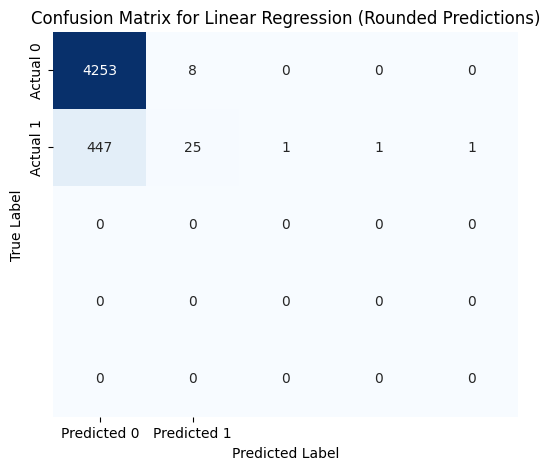

In [ ]:
if 'y_test' in locals() and 'y_pred_lr_reg_classified' in locals():
    cm_lr = confusion_matrix(y_test, y_pred_lr_reg_classified)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Confusion Matrix for Linear Regression (Rounded Predictions)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
else:
    print("Cannot visualize confusion matrix. Linear Regression predictions (y_pred_lr_reg_classified) or test labels (y_test) not available.")

## 4. Discussion and Future Work

This section provides a summary of findings and suggests areas for further improvement or future analysis.

In [26]:
print("\nSummary of Model Performance:")
print("- Logistic Regression provides a good baseline for binary classification of disaster severity.")
print("- Random Forest often captures complex patterns and generally performs well on tabular data, especially with handling class imbalance through `class_weight`.")
print("- Linear Regression, while shown for comparison, is not ideal for classification. Its use here highlights the need for appropriate model selection based on target variable type (continuous vs. categorical).")
print("\nFuture Work:")
print("- Explore more advanced feature engineering, including temporal features (e.g., duration of disaster) and geospatial features (e.g., proximity to coastlines, elevation).")
print("- Implement advanced techniques for handling imbalanced datasets (e.g., SMOTE, ADASYN) to improve the detection of 'severe' disaster events.")
print("- Experiment with other machine learning models (e.g., Gradient Boosting like XGBoost/LightGBM, SVMs) and deep learning models for time-series forecasting or image analysis (if satellite data is integrated).")
print("- Conduct thorough hyperparameter tuning and cross-validation for all models.")
print("- Integrate external data sources, such as real-time weather data, socio-economic indicators, and population density, to enhance predictive power.")
print("- Develop an interpretable AI component to understand which features contribute most to predicting disaster severity.")
print("- Set up a continuous integration/continuous deployment (CI/CD) pipeline for model retraining and deployment.")


Summary of Model Performance:
- Logistic Regression provides a good baseline for binary classification of disaster severity.
- Random Forest often captures complex patterns and generally performs well on tabular data, especially with handling class imbalance through `class_weight`.
- Linear Regression, while shown for comparison, is not ideal for classification. Its use here highlights the need for appropriate model selection based on target variable type (continuous vs. categorical).

Future Work:
- Explore more advanced feature engineering, including temporal features (e.g., duration of disaster) and geospatial features (e.g., proximity to coastlines, elevation).
- Implement advanced techniques for handling imbalanced datasets (e.g., SMOTE, ADASYN) to improve the detection of 'severe' disaster events.
- Experiment with other machine learning models (e.g., Gradient Boosting like XGBoost/LightGBM, SVMs) and deep learning models for time-series forecasting or image analysis (if satelli